<h1 align="center"> Analisis exploratorio de datos<h1>
<h2 align="center"> grupo 6 <h2>
<h3 align="center"> Integrantes: <br>Nhoeli Salazar<br>Juan Carlos Macías<br>Michael López<br>Mariela Adimari<h3>

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [94]:
df = pd.read_csv("../data/bodyPerformance.csv")

print(df.head())
print(df.info())
print(df.describe())

    age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 

### **Descripción**

- Hay 13.393 registros y 12 columnas.

- Las variables son en su mayoría numéricas, salvo gender y class.

- El rango de edad es de 21 a 64 años.

### **Normalizando los nombres de las columnas**


Pudimos observar que los nombres de las columnas no son consistentes, por lo que se procede a normalizarlos, para poder trabajar de manera más eficiente.

In [95]:
# Normalizar nombres de columnas
df.columns = (
    df.columns.str.strip()  # quitar espacios al inicio/final
              .str.lower()  # todo en minúscula
              .str.replace(' ', '_')  # espacios a guiones bajos
              .str.replace('-', '_')  # guiones a guiones bajos
              .str.replace('%', 'percent')  # % a "percent"
              .str.replace('[^0-9a-zA-Z_]', '')  # quitar cualquier otro caracter raro
)
print(df.columns.tolist())

['age', 'gender', 'height_cm', 'weight_kg', 'body_fat_percent', 'diastolic', 'systolic', 'gripforce', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm', 'class']


### **Corroborando los valores minimos y maximos, viendo si hay algunos valores sospechosos, lo cual podría indicar datos erróneos.**

In [96]:
minimums = df.min(numeric_only=True)
maximums = df.max(numeric_only=True)

print("Valores mínimos:")
print(minimums)

print("\nValores máximos:")
print(maximums)


Valores mínimos:
age                         21.0
height_cm                  125.0
weight_kg                   26.3
body_fat_percent             3.0
diastolic                    0.0
systolic                     0.0
gripforce                    0.0
sit_and_bend_forward_cm    -25.0
sit_ups_counts               0.0
broad_jump_cm                0.0
dtype: float64

Valores máximos:
age                         64.0
height_cm                  193.8
weight_kg                  138.1
body_fat_percent            78.4
diastolic                  156.2
systolic                   201.0
gripforce                   70.5
sit_and_bend_forward_cm    213.0
sit_ups_counts              80.0
broad_jump_cm              303.0
dtype: float64


### **Corroborando cuantos valores maximos hay en la columna sit_and_bend_forward_cm, estos outliers pueden entorpecer el modelo**

In [97]:
threshold = 100

filter_mask = df['sit_and_bend_forward_cm'] > threshold
count_above_threshold = filter_mask.sum()
total_rows = len(df)

percentage_above = (count_above_threshold / total_rows) * 100

print(f"Número de valores mayores que {threshold} cm en '{'sit_and_bend_forward_cm'}': {count_above_threshold}")
print(f"Porcentaje total: {percentage_above:.4f}%")

Número de valores mayores que 100 cm en 'sit_and_bend_forward_cm': 2
Porcentaje total: 0.0149%


### **Eliminando las filas de "sit_and_bend_forward_cm" que vimos que tienen valores atipicos**

In [98]:
# Eliminando filas con valores > 100 cm
df_clean = df[df['sit_and_bend_forward_cm'] <= 100]

### **Corroborando que cantidad de valores negativos hay.**

In [99]:
# Valores negativos por columna numérica (solo las que tienen negativos)
negative_values = (df.select_dtypes(include='number') < 0).sum()
negative_values = negative_values[negative_values > 0]
print("Valores negativos por columna:")
print(negative_values)

# Porcentaje de valores negativos en una columna específica
negative_percentage = (df["sit_and_bend_forward_cm"] < 0).mean() * 100
print(f"\nPorcentaje de valores negativos en 'sit_and_bend_forward_cm': {negative_percentage:.2f}%")


Valores negativos por columna:
sit_and_bend_forward_cm    642
dtype: int64

Porcentaje de valores negativos en 'sit_and_bend_forward_cm': 4.79%


### **Vamos a imputar con la mediana estos valores negativos encontrados en la columna "sit_and_bend_forward_cm"**

In [100]:
# Reemplazar valores negativos con NaN
df["sit_and_bend_forward_cm"] = df["sit_and_bend_forward_cm"].apply(lambda x: np.nan if x < 0 else x)

# Calcular la mediana de los valores válidos
median_value = df["sit_and_bend_forward_cm"].median()

# Imputar los NaN con la mediana (sin usar inplace=True)
df["sit_and_bend_forward_cm"] = df["sit_and_bend_forward_cm"].fillna(median_value)

print("Valores negativos restantes:", (df["sit_and_bend_forward_cm"] < 0).sum())


Valores negativos restantes: 0


In [101]:
# Count zeros in each column of the dataset
zeros_per_column = (df == 0).sum()

# Show only columns that have at least one zero
columns_with_zeros = zeros_per_column[zeros_per_column > 0]
print("\nColumns containing at least one zero value:")
print(columns_with_zeros)


Columns containing at least one zero value:
diastolic                    1
systolic                     1
gripforce                    3
sit_and_bend_forward_cm     12
sit_ups_counts             125
broad_jump_cm               10
dtype: int64


### **Podemos observar que en las columnas anteriores hay ceros que procederemos a eliminar o bien a reemplazar por la media de cada columna.**

- **Presión arterial (diastolic y systolic):**


        Solo hay 1 valor cero en cada una, lo cual es muy poco, la presión arterial nunca puede ser cero en una persona viva, así que estos son claramente errores o datos faltantes.

- **gripforce (fuerza de agarre):**


        3 valores cero, la fuerza de agarre no debería ser cero en personas sanas.

- **sit_and_bend_forward_cm (flexibilidad):**


        12 valores cero, podría ser un valor válido en algunas pruebas de flexibilidad, pero es sospechoso.

- **sit_ups_counts (abdominales):**


        125 valores cero - este es un número significativo, cero abdominales podría ser un valor válido si la persona no pudo realizar ninguno.

- **broad_jump_cm (salto de longitud):**


        10 valores cero, un salto de 0 cm no es posible físicamente.

In [102]:
# Reemplazar ceros con la mediana en columnas específicas
columns_to_replace = ['diastolic', 'systolic', 'sit_and_bend_forward_cm']
for column in columns_to_replace:
    median_value = df[df[column] > 0][column].median()
    df.loc[df[column] == 0, column] = median_value
    print(f"Replaced zeros in '{column}' with median: {median_value:.2f}")

# Eliminar filas con gripforce o broad_jump_cm igual a cero
df = df[(df['gripforce'] > 0) & (df['broad_jump_cm'] > 0)]

# Eliminar valores mayores a 100 cm en sit_and_bend_forward_cm
df = df[df['sit_and_bend_forward_cm'] <= 100]

# Guardar el dataset limpio
df.to_csv('../data/clean_data.csv', index=False)

print(f"Cleaned dataset saved with shape: {df.shape}")


Replaced zeros in 'diastolic' with median: 79.00
Replaced zeros in 'systolic' with median: 130.00
Replaced zeros in 'sit_and_bend_forward_cm' with median: 16.60
Cleaned dataset saved with shape: (13378, 12)


* **Columnas donde reemplazamos ceros con la mediana**:
   * `diastolic`
   * `systolic`
   * `sit_and_bend_forward_cm`
* **Columnas donde eliminamos las filas que contenian cero** 
   * `gripforce`
   * `broad_jump_cm`

### **Calculando el indice de masa corporal**

In [103]:
df['height_m'] = df['height_cm'] / 100
df['bmi'] = df['weight_kg'] / (df['height_m'] ** 2)
print(df[['height_cm', 'weight_kg', 'bmi']].head())

   height_cm  weight_kg        bmi
0      172.3      75.24  25.344179
1      165.0      55.80  20.495868
2      179.6      78.00  24.181428
3      174.5      71.10  23.349562
4      173.8      67.70  22.412439


### **Visualizaremos las categorías en la columna Class. (A, B, C, D)**

['C' 'A' 'B' 'D']


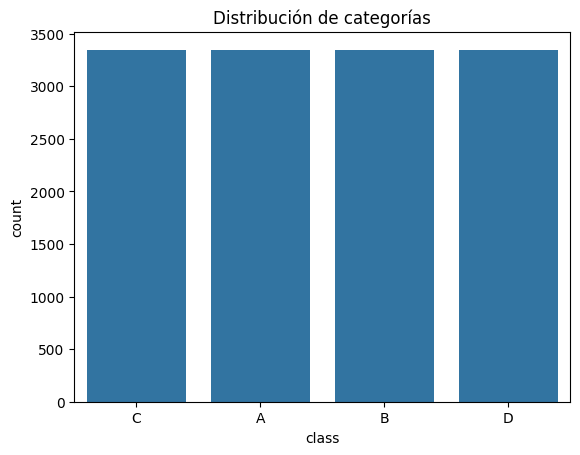

In [104]:
if 'class' in df.columns:
    print(df['class'].unique())
else:
    print("La columna de categorías no se encuentra, verifica el nombre.")

sns.countplot(x='class', data=df)
plt.title("Distribución de categorías")
plt.show()



**🏷️Categorías de rendimiento físico**

Las clases están bastante balanceadas:

    Clase A: 3348

    Clase B: 3347

    Clase C: 3349

    Clase D: 3349

In [105]:
df = pd.read_csv("../data/clean_data.csv")

### **Matriz de Correlación entre Variables Numéricas**

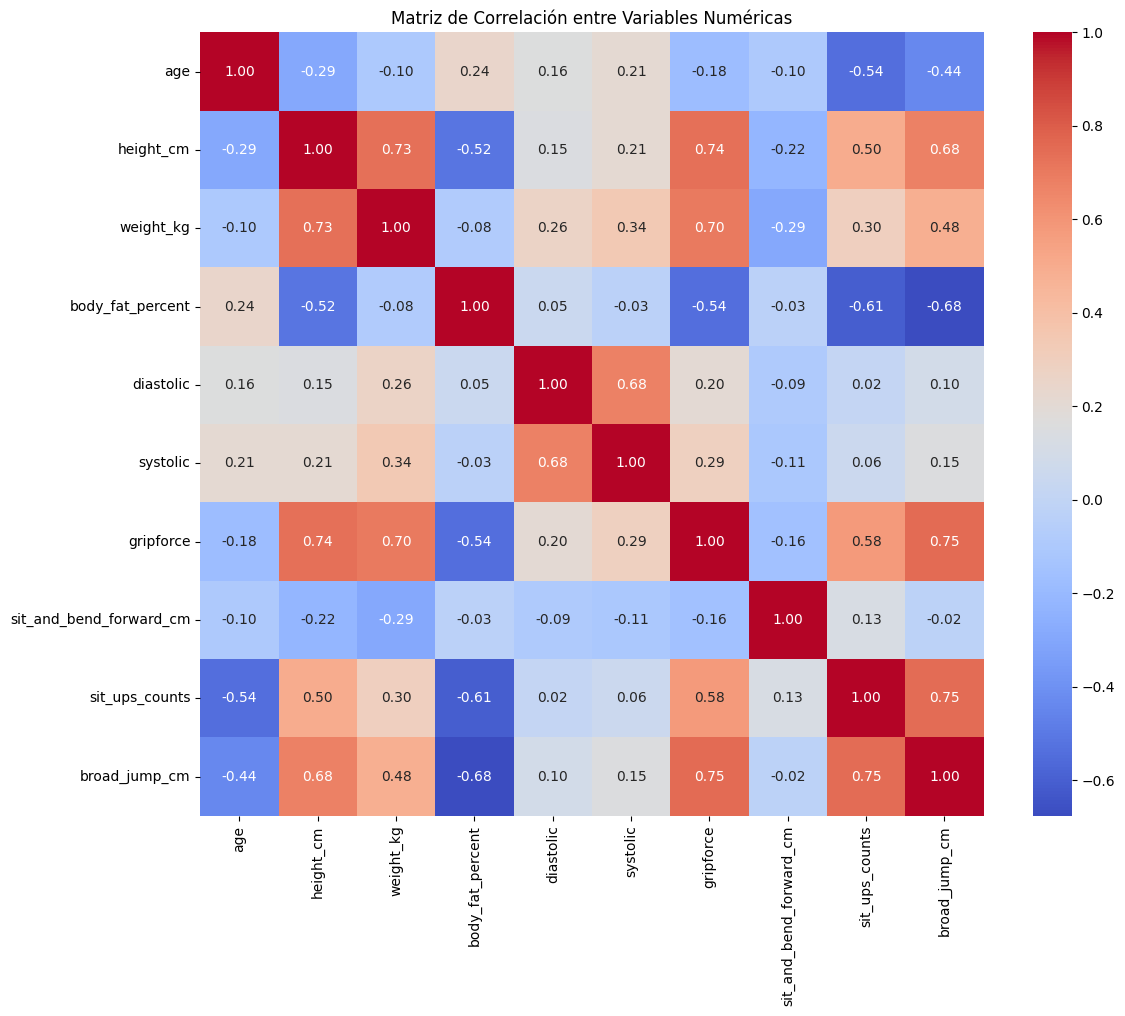

In [106]:
numeric_cols = df.select_dtypes(include=['float64']).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()

### **📌 Hallazgos clave:**

**Gripforce (fuerza de agarre):** Presenta correlaciones fuertes con múltiples variables clave:

    - Correlación muy alta con broad_jump_cm (0.75)
    - Correlación alta con height_cm (0.74)
    - Correlación alta con weight_kg (0.70)
    - Correlación moderada con sit_ups_counts (0.58)
    - Correlación negativa moderada con body_fat_percent (-0.54)


**Broad_jump_cm (salto de longitud):** También muestra correlaciones notables:

    - Correlación alta con gripforce (0.75)
    - Correlación alta con sit_ups_counts (0.75)
    - Correlación alta con height_cm (0.68)
    - Correlación negativa alta con body_fat_percent (-0.68)
    - Correlación negativa moderada con age (-0.44)


**Height_cm (altura):** Variable central con múltiples correlaciones:

    - Correlación alta con weight_kg (0.73)
    - Correlación alta con gripforce (0.74)
    - Correlación alta con broad_jump_cm (0.68)
    - Correlación moderada con sit_ups_counts (0.50)
    - Correlación negativa moderada con body_fat_percent (-0.52)


**Body_fat_percent (porcentaje de grasa corporal):** Variable importante por sus correlaciones negativas:

    - Correlación negativa alta con broad_jump_cm (-0.68)
    - Correlación negativa alta con sit_ups_counts (-0.61)
    - Correlación negativa moderada con height_cm (-0.52)
    - Correlación negativa moderada con gripforce (-0.54)


**Age (edad):** Muestra correlaciones relevantes especialmente con variables de rendimiento:

    - Correlación negativa moderada con sit_ups_counts (-0.54)
    - Correlación negativa moderada con broad_jump_cm (-0.44)

- También destaca la fuerte correlación entre variables presión arterial: diastolic y systolic (0.68).

**Conclusión:** Las variables mas relevantes en el dataset son: 

        gripforce
        broad_jump_cm
        height_cm
        body_fat_percent 

Por su alta interconexión con el resto del conjunto de datos. Estas variables representan aspectos fundamentales de la condición física y el rendimiento de los individuos estudiados.

### **Distribución de las variables numéricas**
Veremos distribuidos los datos en cada columna:

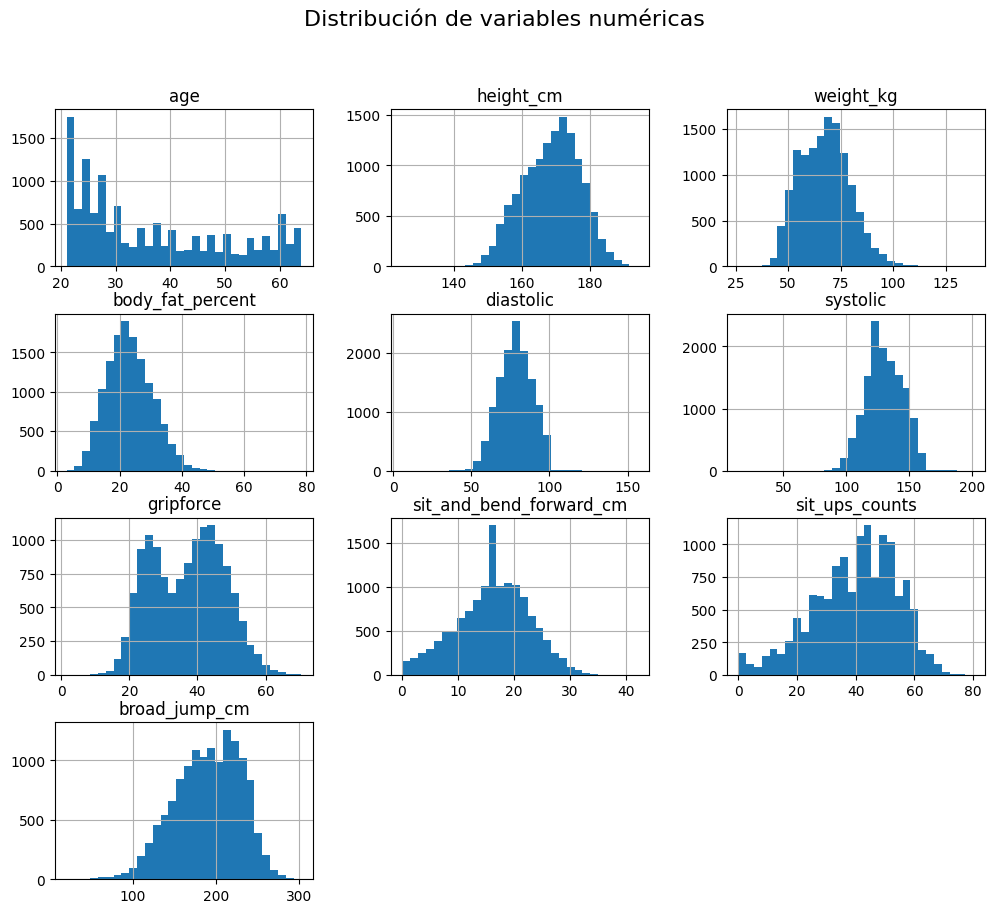

In [107]:
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

- **Edad:** Distribución bimodal con mayor concentración en adultos jóvenes y mediana edad

- **Altura (height_cm):** Distribución normal centrada aproximadamente en 170 cm
- **Peso (weight_kg):** Distribución normal ligeramente sesgada a la derecha con media alrededor de 70 kg
- **Porcentaje de grasa corporal:** Distribución aproximadamente normal centrada en ~25%
- **Presión arterial diastólica:** Concentrada entre 70-90 mmHg
- **Presión arterial sistólica:** Concentrada principalmente entre 120-140 mmHg
- **Fuerza de agarre (gripforce):** Distribución bimodal (posiblemente reflejando diferencias de género)
- **Sit and bend forward:** Muchos valores cercanos a cero, indicando limitada flexibilidad
- **Sit-ups counts:** Distribución amplia desde 0 hasta ~70 repeticiones
- **Broad jump:** Distribución aproximadamente normal centrada en ~170-180 cm

### **Boxplots para analizar la variabilidad y posibles valores atípicos**
Esto es útil para ver la dispersión de los datos y detectar outliers:

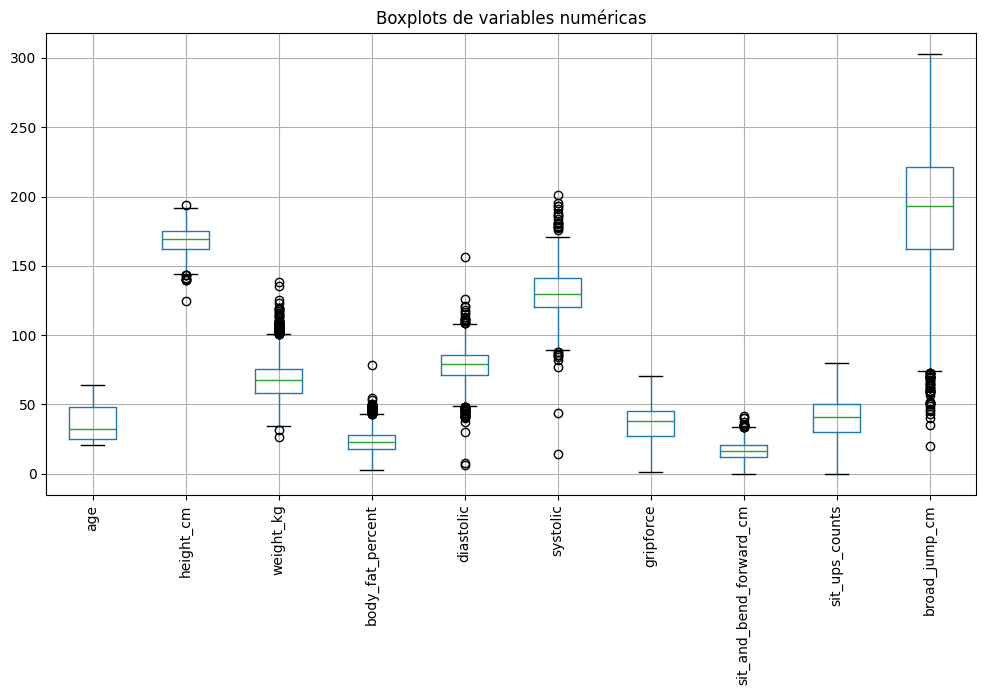

In [108]:
df = pd.read_csv("../data/clean_data.csv")
plt.figure(figsize=(12,6))
df.boxplot(rot=90)
plt.title("Boxplots de variables numéricas")
plt.show()

- **Distribución de variables:** Cada boxplot muestra el rango intercuartílico (caja), la mediana (línea dentro de la caja), los "bigotes" (extensiones) y valores atípicos (puntos individuales).

- **Variables antropométricas:**
    - height_cm: Presenta valores alrededor de 160-180 cm, con poca dispersión y pocos valores  atípicos.
    - weight_kg: Muestra una distribución centrada aproximadamente en 70 kg.
    - body_fat_percent: Tiene valores bajos (20-30%) con algunos valores atípicos.

- **Variables médicas:**
    - diastolic y systolic: Representan presión arterial, con valores típicos para systolic entre 120-140 y diastolic entre 70-90.
    - age: Muestra una distribución con mediana alrededor de 30 años.

- **Variables de rendimiento físico:**
    - sit_and_bend_forward_cm: Medición de flexibilidad con valores moderados.
    - sit_ups_counts: Número de abdominales, con distribución amplia.
    - broad_jump_cm: Salto de longitud, con la mayor variabilidad y valores entre 150-220 cm aproximadamente.
    - gripforce: Probablemente fuerza de agarre, con distribución moderada.

- **Comportamiento de los datos:**
broad_jump_cm presenta la mayor dispersión y algunos valores atípicos extremos.
Varios boxplots muestran valores atípicos, particularmente notables en systolic y height_cm.

### **Gráfico de violín por categoría**
Este gráfico ayudará a ver la distribución de una variable según la categoría:

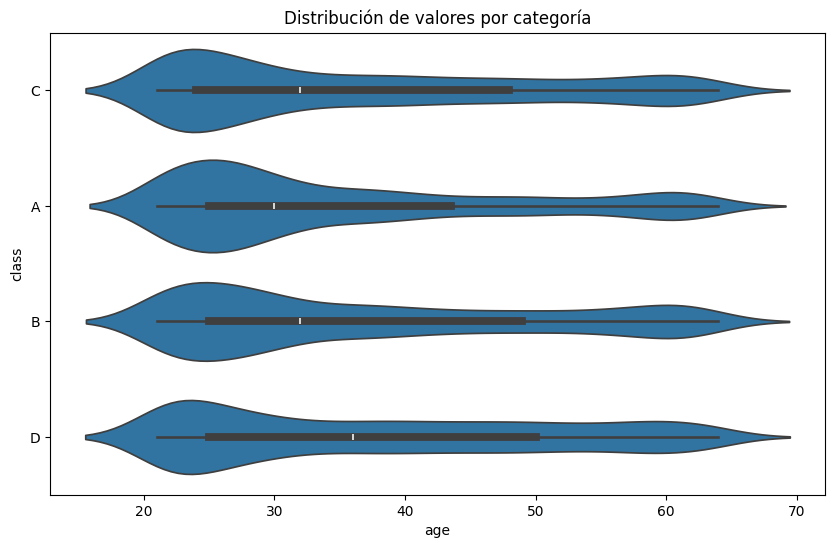

In [109]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="age", y="class", data=df) 
plt.title("Distribución de valores por categoría")
plt.show()

- Todas las clases muestran distribuciones de edad similares con ligeras variaciones

- Las cuatro clases presentan una distribución bimodal de edad
- Las medianas (líneas blancas) son muy similares entre clases
- La distribución de edad no parece ser un factor determinante en la clasificación
- Todas las clases abarcan aproximadamente el mismo rango de edad (20-70 años)

### **Heatmap de correlación con más detalle**
Visualizar cómo están distribuidas la columna categorica gender:

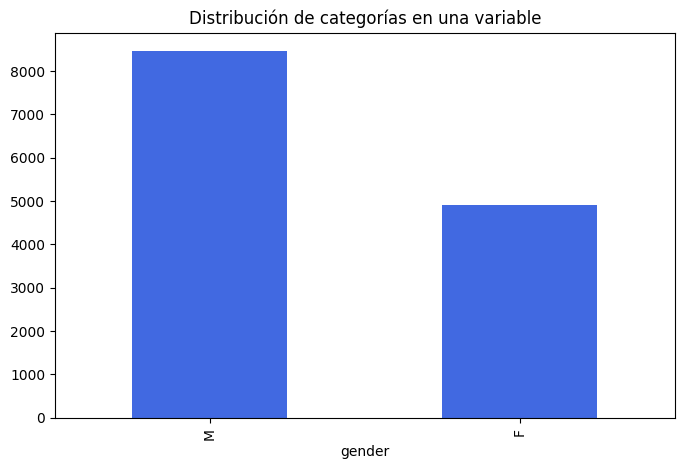

In [110]:
plt.figure(figsize=(8,5))
df['gender'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Distribución de categorías en una variable")
plt.show()

**Hallazgos:**

- Aproximadamente 8,000 individuos masculinos (M)
- Aproximadamente 5,000 individuos femeninos (F)
- Desbalance de aproximadamente 60% hombres y 40% mujeres en la muestra
- Esta proporción desigual debe considerarse al interpretar los resultados generales

### **Ver la distribución de clases según el género.**

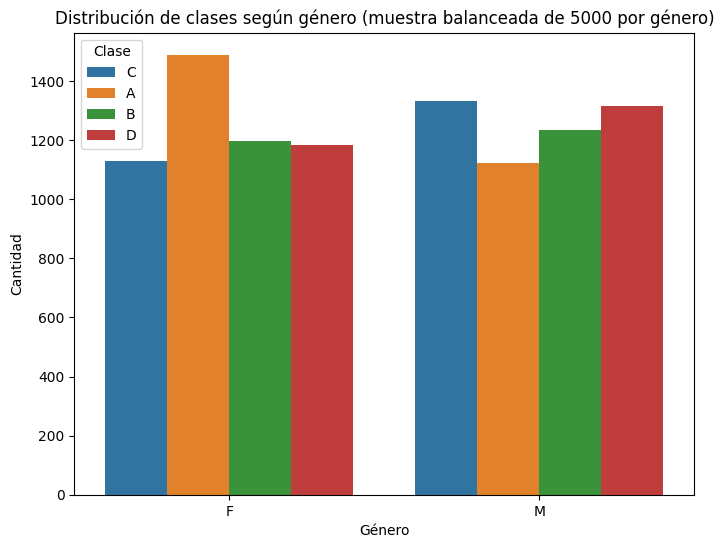

In [111]:
# separando el dataframe por género
female_df = df[df['gender'] == 'F']  
male_df = df[df['gender'] == 'M']      

# Muestra aleatoria de cada grupo de 5000 filas
female_sample = female_df.sample(n=5000, random_state=42, replace=len(female_df) < 5000)
male_sample = male_df.sample(n=5000, random_state=42, replace=len(male_df) < 5000)

# Combinando las muestras en un nuevo dataframe
balanced_df = pd.concat([female_sample, male_sample])

# Gráfico con el dataframe balanceado
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_df, x="gender", hue="class")
plt.title("Distribución de clases según género (muestra balanceada de 5000 por género)")
plt.xlabel("Género")
plt.ylabel("Cantidad")
plt.legend(title="Clase")
plt.show()

### Distribución de clases por género

| Género | Observaciones Principales                                   |
|--------|-------------------------------------------------------------|
| **Hombres (M)** | - Clase **C**: Predominante (~1330 individuos, 26.6%) <br> - Clase **D**: Segunda más común (~1300 individuos, 26%) <br> - Clase **B**: Moderada (~1250 individuos, 25%) <br> - Clase **A**: Menos representada (~1120 individuos, 22.4%)            |
| **Mujeres (F)** | - Clase **A**: Predominante (~1500 individuos, 30%) <br> - Clases **B**, **C** y **D**: Distribución relativamente uniforme (~1130-1200 individuos, 22-24%)            |

**Implicaciones críticas:**

- Hay una inversión clara: la clase **A** domina en mujeres mientras **C** y **D** predominan en hombres.
- La clase **A** es 34% más frecuente en mujeres que en hombres.
- La clase **C** es 18% más frecuente en hombres que en mujeres.

Este patrón sugiere que la clasificación podría estar relacionada con características físicas dependientes del género.

### **Comparar diferencias entre géneros para una variable específica**
Porcentaje de grasa corporal por género (muestra balanceada: 5000 por género)

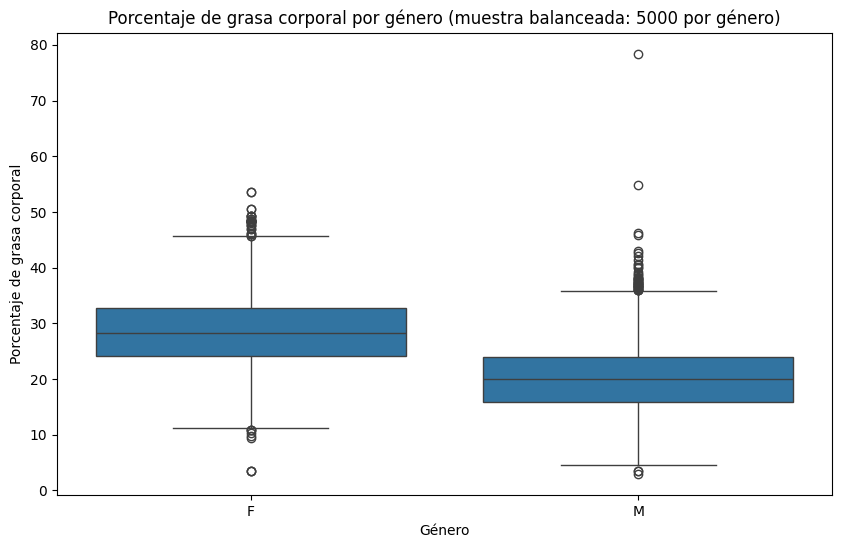

In [112]:

female_df = df[df['gender'] == 'F']
male_df = df[df['gender'] == 'M']      

female_sample = female_df.sample(n=5000, random_state=42, replace=len(female_df) < 5000)
male_sample = male_df.sample(n=5000, random_state=42, replace=len(male_df) < 5000)

# Combinando muestras en un nuevo dataframe balanceado
balanced_df = pd.concat([female_sample, male_sample])

# Boxplot con los datos balanceados
plt.figure(figsize=(10, 6))
sns.boxplot(data=balanced_df, x="gender", y="body_fat_percent")
plt.title("Porcentaje de grasa corporal por género (muestra balanceada: 5000 por género)")
plt.xlabel("Género")
plt.ylabel("Porcentaje de grasa corporal")
plt.show()

Este boxplot revela detalles importantes sobre la distribución del porcentaje de grasa corporal:

**Mujeres (F):**

- Mediana de aproximadamente 28%
- Rango intercuartílico entre 24-32%
- Valores extremos desde 11% hasta 55%

**Hombres (M):**

- Mediana de aproximadamente 19%
- Rango intercuartílico entre 16-23%
- Valores extremos desde 4% hasta 78%

**Observaciones clave:**

- La diferencia entre medianas (~9 puntos porcentuales) es consistente con diferencias fisiológicas conocidas.
- Los rangos intercuartílicos no se superponen, indicando una clara separación entre géneros.
- Los hombres presentan más valores atípicos altos extremos, sugiriendo casos excepcionales de obesidad.
- El percentil 75 de hombres (~23%) es aproximadamente equivalente al percentil 25 de mujeres (~24%).

### **Promedio de variables físicas por género (muestra balanceada: 5000)**

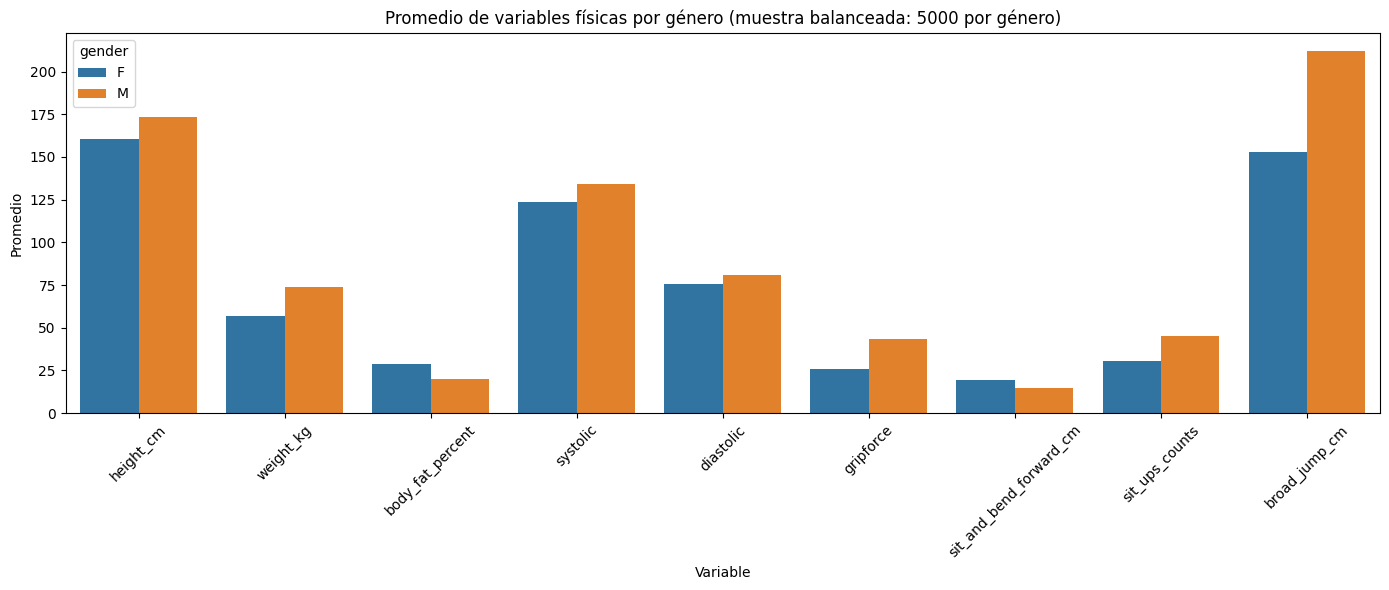

In [113]:
female_df = df[df['gender'] == 'F']  
male_df = df[df['gender'] == 'M']      

female_sample = female_df.sample(n=5000, random_state=42, replace=len(female_df) < 5000)
male_sample = male_df.sample(n=5000, random_state=42, replace=len(male_df) < 5000)

balanced_df = pd.concat([female_sample, male_sample])

variables = ['height_cm', 'weight_kg', 'body_fat_percent', 'systolic', 'diastolic', 
             'gripforce', 'sit_and_bend_forward_cm', 'sit_ups_counts', 'broad_jump_cm']

# Calculando los promedios por género usando el dataframe balanceado
mean_by_gender = balanced_df.groupby('gender')[variables].mean().reset_index()

# Conviertiendo em formato largo para seaborn
mean_long = mean_by_gender.melt(id_vars='gender', var_name='Variable', value_name='Promedio')

# Gráfico con los datos balanceados
plt.figure(figsize=(14, 6))
sns.barplot(data=mean_long, x='Variable', y='Promedio', hue='gender')
plt.title('Promedio de variables físicas por género (muestra balanceada: 5000 por género)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Variables Antropométricas:**

- **Altura (height_cm):** Los hombres son considerablemente más altos (~173 cm vs ~160 cm), una diferencia de aproximadamente 8%.

- **Peso (weight_kg):** Los hombres pesan sustancialmente más (~73 kg vs ~55 kg), una diferencia del 33%.
- **Porcentaje de grasa corporal:** Las mujeres presentan valores significativamente más altos (~28% vs ~21%), aproximadamente un 33% superior, siendo una de las pocas variables donde superan a los hombres.

**Indicadores Cardiovasculares:**

- **Presión sistólica:** Los hombres muestran valores ligeramente más elevados (~133 mmHg vs ~123 mmHg).

- **Presión diastólica:** También mayor en hombres (~80 mmHg vs ~75 mmHg).

**Rendimiento Físico:**

- **Fuerza de agarre:** Los hombres presentan valores considerablemente superiores (~42 vs ~25 unidades), un 68% más.

- **Flexibilidad (sit_and_bend_forward_cm):** Las mujeres superan a los hombres (~19 cm vs ~15 cm), aproximadamente un 27% mejor.
- **Abdominales:** Los hombres realizan aproximadamente 50% más (~45 vs ~30).
- **Salto horizontal:** Muestra la diferencia más pronunciada, con hombres alcanzando ~210 cm vs ~150 cm en mujeres (40% superior).

### **Conclusión General de los analisis por genero**
Analizando las tres visualizaciones presentadas, emerge un panorama completo sobre las diferencias biométricas entre géneros y su impacto en sistemas de clasificación:

**Anatomia**

El conjunto de datos muestra claras diferencias biológicas entre géneros que siguen patrones científicamente documentados. Los hombres predominan en métricas relacionadas con fuerza, altura, peso y capacidad explosiva (salto horizontal), mientras las mujeres presentan mayor porcentaje de grasa corporal y mejor flexibilidad. Estas diferencias no son simplemente marginales, sino sustanciales: 40% de diferencia en salto horizontal, 68% en fuerza de agarre, y 33% en porcentaje de grasa corporal.

**Correlación Entre Rendimiento Físico y Clasificación**

La distribución asimétrica de clases entre géneros (predominio de clase A en mujeres; C y D en hombres) sugiere fuertemente que el sistema de clasificación está relacionado con las variables físicas que exhiben una mayor diferenciación entre los sexos. Este hallazgo es crucial pues indica que la clasificación podría estar utilizando criterios que naturalmente favorecen a un género sobre otro, sin necesariamente considerar las diferencias fisiológicas inherentes.

**Implicaciones para Modelos Predictivos y Toma de Decisiones**

Se identifica un riesgo potencial de sesgo algorítmico si estas variables se utilizan como predictores sin ajustes por género. Un modelo entrenado con estas variables podría confundir diferencias fisiológicas normales con otros factores de interés. La no-superposición de rangos en variables clave (especialmente grasa corporal) significa que cualquier umbral fijo inevitablemente tratará a los géneros de manera diferencial.

### **Media y desviación estándar de sit-ups por clase**
Este gráfico de barras con barras de error muestra el rendimiento promedio en sit-ups para cada clase.

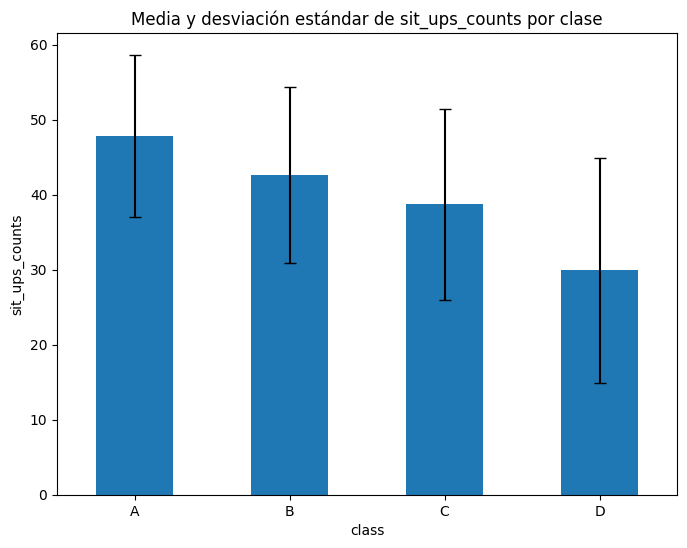

In [114]:
feature = "sit_ups_counts"  
grouped = df.groupby("class")[feature].agg(["mean", "std"]).sort_index()

grouped.plot(kind="bar", y="mean", yerr="std", legend=False, figsize=(8,6), capsize=4)
plt.title(f"Media y desviación estándar de {feature} por clase")
plt.ylabel(feature)
plt.xticks(rotation=0)
plt.show()

**Hallazgos:**

- **Clase A:** Mayor promedio de sit-ups (~48) con desviación estándar de ~10

- **Clase B:** Segundo mejor rendimiento (~42) con desviación estándar similar
- **Clase C:** Rendimiento moderado (~38) con desviación estándar ~12
- **Clase D:** Menor rendimiento (~30) con mayor variabilidad (desviación estándar ~15)
- **Patrón claro:** A > B > C > D en términos de rendimiento en sit-ups
- **Las barras de error (desviación estándar)** muestran superposición, indicando que las diferencias, aunque claras en promedio, tienen variabilidad significativa

### **Visualizar la distribución de una variable como por clase**
Este gráfico radar compara el perfil promedio de cada clase a través de múltiples variables.

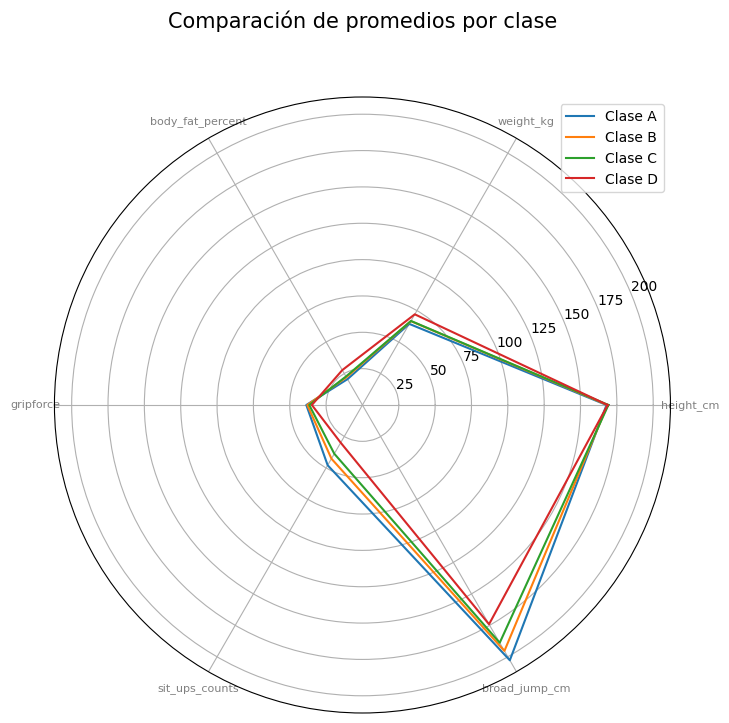

In [115]:
# Preparamos promedios por clase
features = ['height_cm', 'weight_kg', 'body_fat_percent', 'gripforce', 'sit_ups_counts', 'broad_jump_cm']
df_mean = df.groupby("class")[features].mean()

# Radar chart
categories = features
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar el círculo

plt.figure(figsize=(8, 8))
for idx, row in df_mean.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Clase {idx}')
    
plt.xticks(angles[:-1], categories, color='grey', size=8)
plt.title('Comparación de promedios por clase', size=15, y=1.1)
plt.legend()
plt.show()


**Hallazgos principales:**

- **Clase A (azul):** Destaca en broad_jump_cm y sit_ups_counts, menor en body_fat_percent

- **Clase D (rojo):** Mayor en body_fat_percent, menor en broad_jump_cm y sit_ups_counts
- **Clases B y C:** Perfiles intermedios entre A y D
- Todas las clases muestran valores similares en height_cm
- La forma del polígono sugiere que las clases representan niveles de aptitud física, con A siendo la más alta y D la más baja
- El gráfico confirma la relación inversa entre porcentaje de grasa corporal y rendimiento físico

### **Promedios por clase para variables seleccionadas (Heatmap)**

Este mapa de calor muestra los valores promedio de cada variable por clase, con la intensidad del color representando el valor.

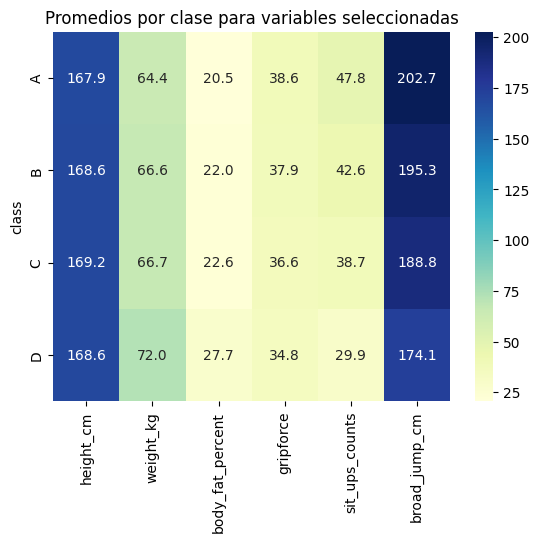

In [116]:
mean_by_class = df.groupby('class')[features].mean()
sns.heatmap(mean_by_class, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Promedios por clase para variables seleccionadas")
plt.show()


**Hallazgos principales:**

- **Altura (height_cm):** Valores similares entre clases (~168-169 cm)

- **Peso (weight_kg):** Aumenta progresivamente de clase A (64.4) a D (72.0)
- **Body fat percent:** Aumenta progresivamente de clase A (20.5%) a D (27.7%)
- **Fuerza de agarre:** Disminuye de clase A (38.6) a D (34.7)
- **Sit-ups counts:** Disminuye significativamente de clase A (47.8) a D (29.9)
- **Broad jump:** Disminuye de clase A (202.7 cm) a D (173.8 cm)
- Se confirma el patrón de aptitud física decreciente de A→D
- La clase D se caracteriza por mayor peso y grasa corporal, pero menor rendimiento físico

### **Fuerza de agarre vs. abdominales, coloreado por clase**

Este gráfico de dispersión muestra la relación entre fuerza de agarre (eje X) y repeticiones de abdominales (eje Y), con puntos coloreados según la clase.

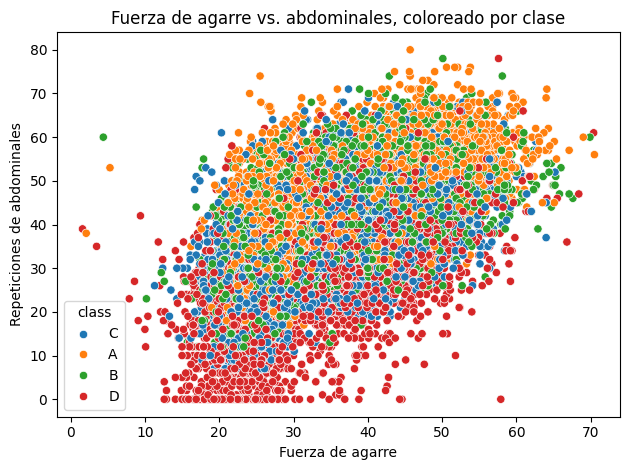

In [117]:
# Relación entre fuerza de agarre y abdominales por clase
plt.figure()
sns.scatterplot(x="gripforce", y="sit_ups_counts", hue="class", data=df)
plt.title("Fuerza de agarre vs. abdominales, coloreado por clase")
plt.xlabel("Fuerza de agarre")
plt.ylabel("Repeticiones de abdominales")
plt.tight_layout()
plt.show()

- Correlación positiva moderada-fuerte entre fuerza de agarre y capacidad de abdominales

- Clase A (naranja): Concentrada en región superior derecha (alto rendimiento en ambas variables)
- Clase D (rojo): Concentrada en región inferior (bajo rendimiento en abdominales)
- Clases B y C: Distribución más amplia a través del gráfico
- Existe un número significativo de individuos con valor cero en abdominales, especialmente en clase D
- La correlación positiva confirma que la fuerza general puede ser un predictor de rendimiento en abdominales

### **Scatter Plot relacionando variables**

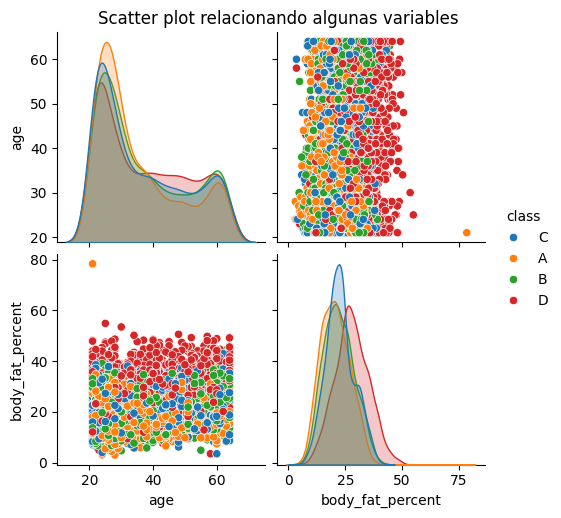

In [118]:
cols = ["age", "body_fat_percent"] 
sns.pairplot(df[cols + ["class"]], hue="class")  # Solo esas columnas + la de hue
plt.gcf().suptitle("Scatter plot relacionando algunas variables", y=1.02) 
plt.show()

**Hallazgos principales:**

- La distribución de edad muestra un patrón bimodal con picos alrededor de 25 y 35 años
- No hay una separación clara de las clases por edad (panel superior derecho)
- El porcentaje de grasa corporal no muestra una fuerte relación con la edad (panel inferior izquierdo)
- La distribución del porcentaje de grasa corporal (panel inferior derecho) es aproximadamente normal con un ligero sesgo positivo
- Las clases (A, B, C, D) parecen distribuirse uniformemente a través de las variables visualizadas, sin mostrar agrupación clara

### **Matriz de gráficos de dispersión para variables mas importantes**

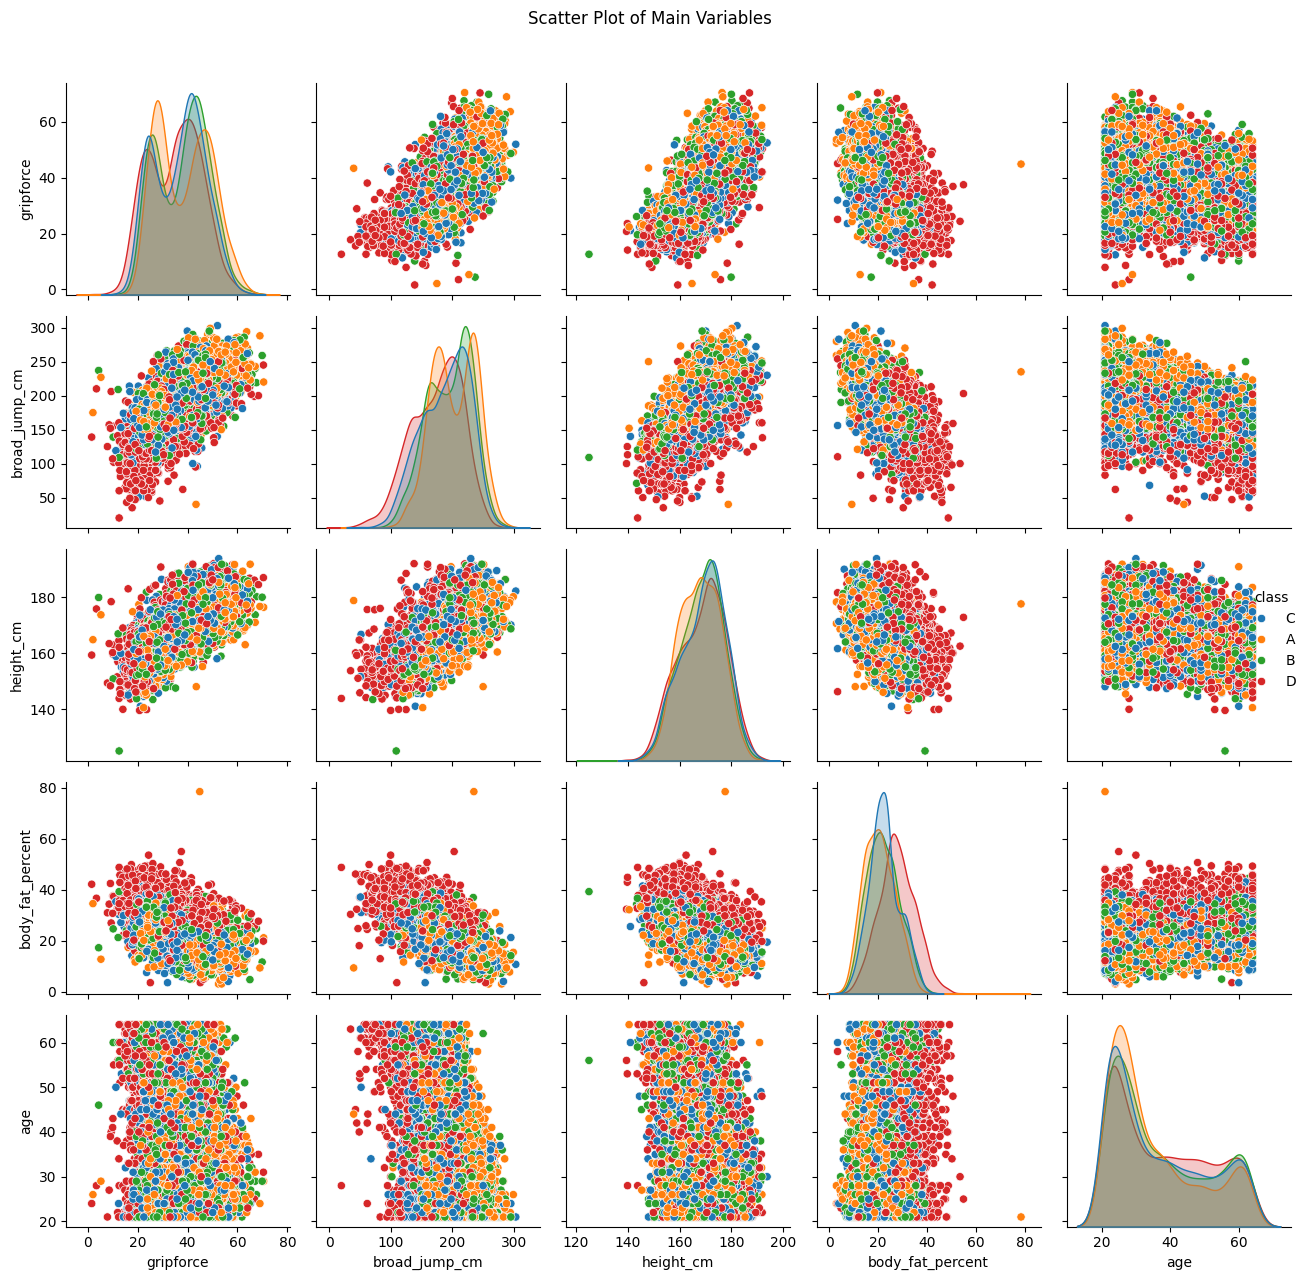

In [119]:
sns.pairplot(df, vars=['gripforce', 'broad_jump_cm', 'height_cm', 'body_fat_percent', 'age'], hue="class")
plt.suptitle("Scatter Plot of Main Variables", y=1.02)
plt.tight_layout()
plt.show()

**Relaciones entre variables:**

- **Gripforce (fuerza de agarre) vs broad_jump_cm:** Se observa una correlación positiva moderada. A mayor fuerza de agarre, mayor capacidad de salto, lo que sugiere una relación entre fuerza muscular superior e inferior.
- **Height_cm vs broad_jump_cm:** Correlación positiva clara. Las personas más altas tienden a tener mejor rendimiento en salto, probablemente por la ventaja biomecánica de extremidades más largas.
- **Body_fat_percent vs broad_jump_cm:** Correlación negativa evidente. A mayor porcentaje de grasa corporal, menor rendimiento en salto, indicando que el exceso de grasa afecta negativamente el rendimiento físico.
- **Age vs otras variables:** Distribución bimodal interesante (dos picos) que sugiere posiblemente dos grupos de edad distintos en la muestra.

**Patrones por clase:**

- **Clase A (azul):** Tiende a mostrar valores medios en la mayoría de variables, con distribución relativamente uniforme.
- **Clase B (naranja):** Generalmente muestra mejor rendimiento físico (mayor fuerza de agarre y distancia de salto) y menor porcentaje de grasa corporal.
- **Clase C (verde):** Aparece con menos frecuencia pero con valores dispersos, posiblemente representando casos atípicos o un grupo específico menos numeroso.
- **Clase D (rojo):** Muestra claramente menor rendimiento físico (menor fuerza de agarre y distancia de salto) y mayor porcentaje de grasa corporal. Predomina en la zona inferior de rendimiento.

Estos patrones sugieren que las variables seleccionadas son efectivamente importantes para clasificar a los individuos en estos grupos, confirmando su relevancia como predictores. Confirma las correlaciones observadas en la matriz de correlación.